# Subpixel Effects

## A. H. Jaffe

%\title{Subpixel effects}
%\author{A.H. Jaffe}
%\maketitle


### Todo

* ensemble average
* realistic (shear) spectra
* effect on the sphere (or at least correctly match $k$ - $\ell$)
* 3D?
* How does effect vary with different high-res models?
* CMB effect -- "junk bin"?

## Averaging, Sampling, and aliasing (in 2D)

We need to model the effect of several operations on the data at the pixel scale, resulting from the fact that we are using a pixelized map. There are several interlocking, but distinct, effects:

* We *average* the shear in (square or healpix) pixels
* We *down-sample* only non-overlapping pixels
* We *poisson-sample* within a pixel to compute the above average (note different use of "sample")

Each of these has a calculable effect on the resulting power spectrum:

* (Running) averaging: convolution with 2-D tophat kernel (Fourier transform of top-hat kernel).
    * Note that we use the window for a *circular* pixel of the same area, $L^2=\pi R^2$, $W=2J_1(kR)/kR$.
* Down-sampling: effectively multiplication in real space by a 2D comb, equivalent to *convolution with a 2D Dirac comb* in Fourier space.
    * In more than one dimension, this is relatively complicated, and brings in power from a variety of scales.
* Poisson-sampling:
    * Details TBC, but it's a small effect, something like $(k\sigma)^2P(k)$ where $\sigma$ is related to the variance of the galaxy locations within a pixel, and should satsify $k\sigma\ll1$ for $k<k_\textrm{Ny}$ if there are many samples.

This document will investigate the case of a scalar field on a 2-dimensional flat, square map, sampled into square pixels.

## Aliasing in 2D


In one dimension, aliasing is simple to understand: it folds the high-frequency part of the spectrum (above Nyquist) down into low frequencies. In more than one dimension, especially when we want to reduce down to a power spectrum indexed only by $k$, things are harder to picture, and the overall effect is more complicated.

Consider a function $g(\vec{x})$ with transform ${\tilde g}({\vec k})$. Now consider the related function $g_L({\vec x}) = g({\vec x})\times \varpi_L({\vec x})$ where $\varpi_L$ is a Dirac comb with 2-D spacing $L$, with $L$ the eventual sampling scale (i.e., pixel size). The transform of $\varpi_L$ is itself proportional to a Dirac comb with spacing (in wavenumber) $2\pi/L$, and so the transform of $g_L$ is the convolution of ${\tilde g}$ with $(1/L^2)\varpi_{2\pi/L}$, or $$
    {\tilde g}_L({\vec k}) = \frac{1}{L^2}\sum_{\vec n} {\tilde g}\left({\vec k} + 2\pi{\vec n}/L\right)\;.
$$
where ${\vec n}$ is an integer vector.
Note the units here: ${\vec k}$ is an actual wavenumber (units of inverse length). A good way to think of the effect is to consider the case where $g$ is computed on a finite area with side $NL$ (where $L$ will be the sampling spacing later). In this case, ${\vec k}=2\pi{\vec m}/(NL)$ is the wavenumber, and the argument of ${\tilde g}$ in the sum above is $$
    {\vec q}_{\vec n} = {\vec k} + 2\pi{\vec n}/L \to \frac{2\pi}{NL}\left({\vec m} + {\vec n}N\right)
$$
This is relatively straightforward: at any wavevector ${\vec k}$, aliasing pulls in power (not really power, but "amplitude") from a grid in wavenumber.

It gets more complicated when we consider the power spectrum. Up to constant factors, the power at a vector wavenumber ${\vec k}=2\pi{\vec m}/(NL)$ is approximately $$
    \left< |{\tilde g}_L(\vec k)|^2 \right> \propto \sum_{\vec n} P_g\left(\frac{2\pi}{NL}\left|{\vec m} + {\vec n}N\right|\right)
$$
where $P_g(k)$ is the "raw" power spectrum of $g$. But the left-hand side is still evaluated at a particular *vector* wavenumber ${\vec k}$ (or ${\vec m}$). To get the isotropic power, we have to average over all wavevectors in a sufficiently thin ring with $k=|{\vec k}|$, with the achievable width given roughly by the size of the patch, $\Delta k\sim 2\pi/(NL)$. But this means that we pull in a very large set of raw wavenumbers $|{\vec m} + {\vec n}N|$ at every observed $|m|$. Moreover, for larger $|m|$, we sample from a larger set of more widely separated different $|{\vec m} + {\vec n}N|$, since the ring has a larger radius and so the sets of sampled wavenumber grids are offset from one another. 

(Would it be useful to make a figure here?)

In [1]:
from __future__ import print_function

import math

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
xsize, ysize = 12,8
plt.rcParams['figure.figsize'] = (xsize, ysize)
plt.rcParams['font.size'] = 12

In [2]:
from realization import pixel_sample as pixs

### Test 1 — with beam-smeared pixels

#### Inputs
* Set up a realization of a broken power-law spectrum in 2D, further modified by a Gaussian beam.
* Start with `n_in` $\times$ `n_in` field (representing the high-res "unsampled" field) and average down to `n_out` $\times$ `n_out`

#### Processing on the field
* Poisson sampling: averaging `n_per_pix` randomly-selected samples of the `n_in` field per `n_out` pixels
* Averaging: running average over all `n_in` pixels. Two versions:
    * True running average (i.e., same number of input and output pixels). Here `n_out` is just used to get the width of the averaging kernel.
    * Sampled and averaged: only retain `n_out` pixels (so all input data only contribute to one output pixel)

#### Processing on the spectra
* Calculate $W(k)$ = the window function due to top-hat averaging
* Calculate the effect of sampling into `n_out` pixels on the averaged field
  
#### Figures

I show two figures, one with the P(k), another with all of them divided by the input theory. They are separated out here into groups that are approximately equal

* Theory: the broken power-law $\times$ beam
* raw $P(k)$: input spectrum of the unsampled field
* runavg unwin $P(k)$: runavg $P(k) / W^2(k)$ at *all* `n_in` input pixels
    * So the realization is faithful down to below the `n_out` pixel scale, and the averaging is accounted for by the Fourier kernel, as expected


* B: Poisson $P(k)$: spectrum of sub-sampled field in only `n_out` pixels — this is the closest to our initial calculation (before attempted to account for the window function)
* B: sampled avg $P(k)$: spectrum of the averaged field at only `n_out` pixels 
    * This shows that Poisson and true averaging have very nearly the same effect.


* runavg $P(k)$: spectrum of the averaged field at *all* `n_in` input pixels (i.e., true running average)


* C: Poisson unwin $P(k)$: Poisson $P(k) / W^2(k)$ — this is the closest to what we usually present
* C: sampled avg unwin $P(k)$: sampled runavg $P(k) / W^2(k)$
* C: aliased theory: the effect of sampling on the theory $P(k)$ as detailed above (as displayed, this also divides out by the window function at each $k$)
    * This shows that we can calculate the effect of the down-sampling into final pixels, but that it does have an important effect from around the pixel scale.

#### Results
* For a relatively high number of samples per `n_out` pixel, the difference between true and Poisson averaging is small (Poisson $\simeq$ sampled runavg) (but it does have an effect as the number of samples shrinks). It also depends on the scale length of the theory, and the relation of the pixel scales and the beam.
* Prior to sub-sampling from `n_in` to `n_out`, this averaging is accounted for by the window function,
* Sub-sampling into `n_out` pixels has an important aliasing effect. We can calculate this *for a specific model of high-frequency (sub-pixel) power*.


Number of sub-pix per pix =256
cf. n_per_pix = 512
dims= (1024, 1024)
delta_k: shape= (1024, 513)
delta_r: shape= (1024, 1024)
shape_in (1024, 1024)
shape_out (64, 64)
len=1048576
vals[2097152]: 1.46282e-05 ± 0.0240871
final shape: (64, 64)
good/total: 4096/4096
orig: -1.0842e-19 ± 0.0240889
sampled: 9.41133e-06 ± 0.0222848
P[0]/eP[0]=7.29023e-32, shrink**4=65536
full spectra plotted. P[0]=6.77085e-36
sampled spectra plotted, eP[0]=9.28757e-05


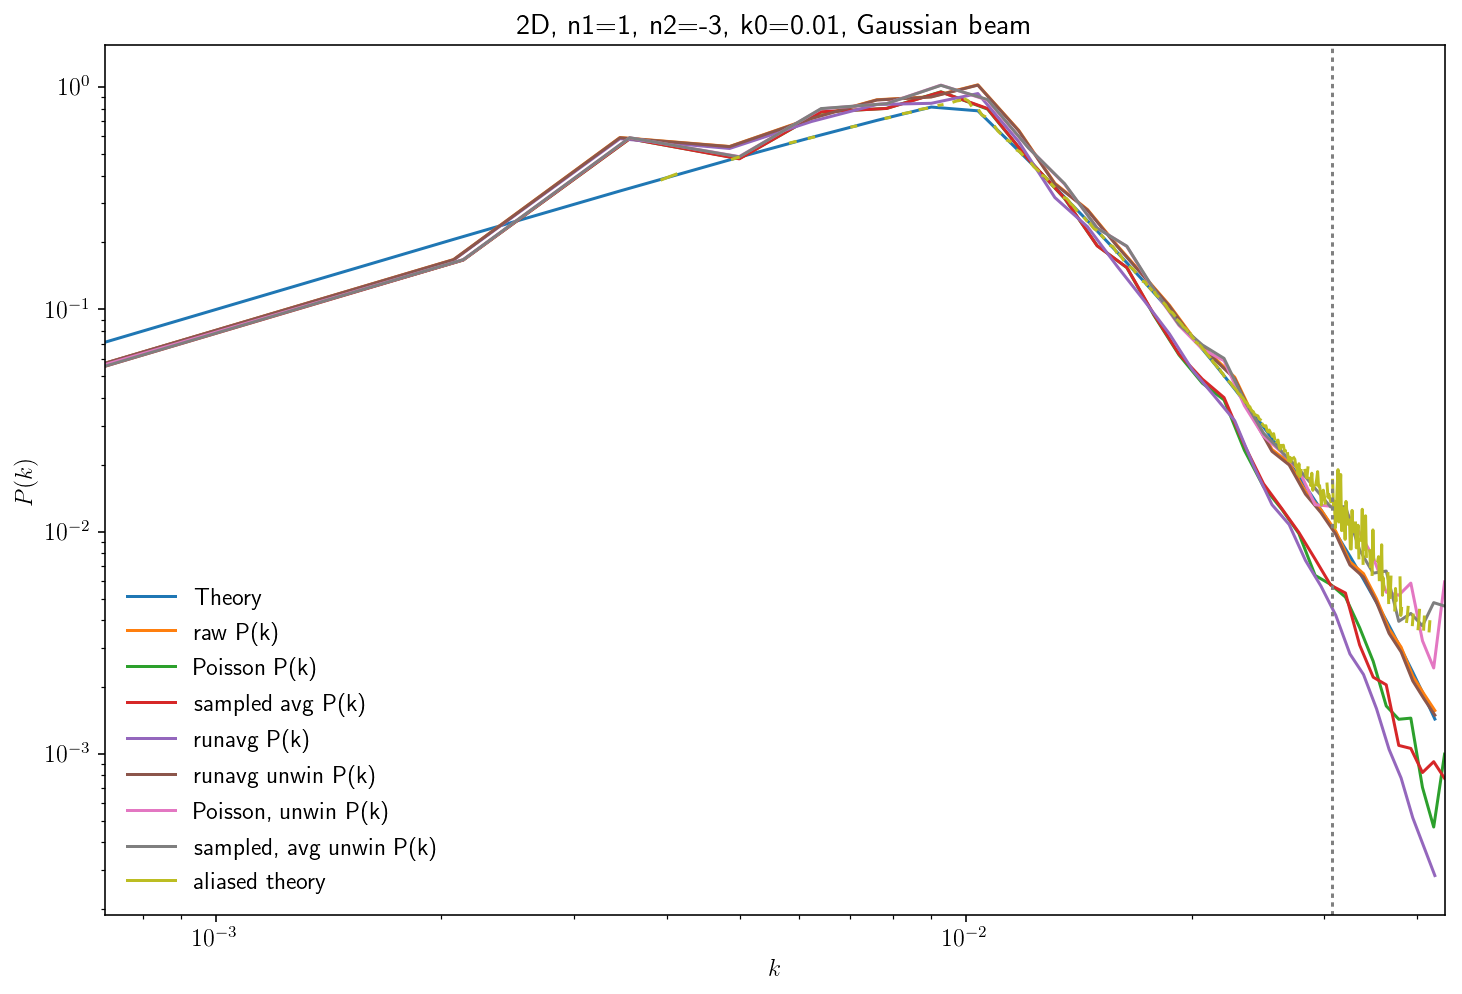

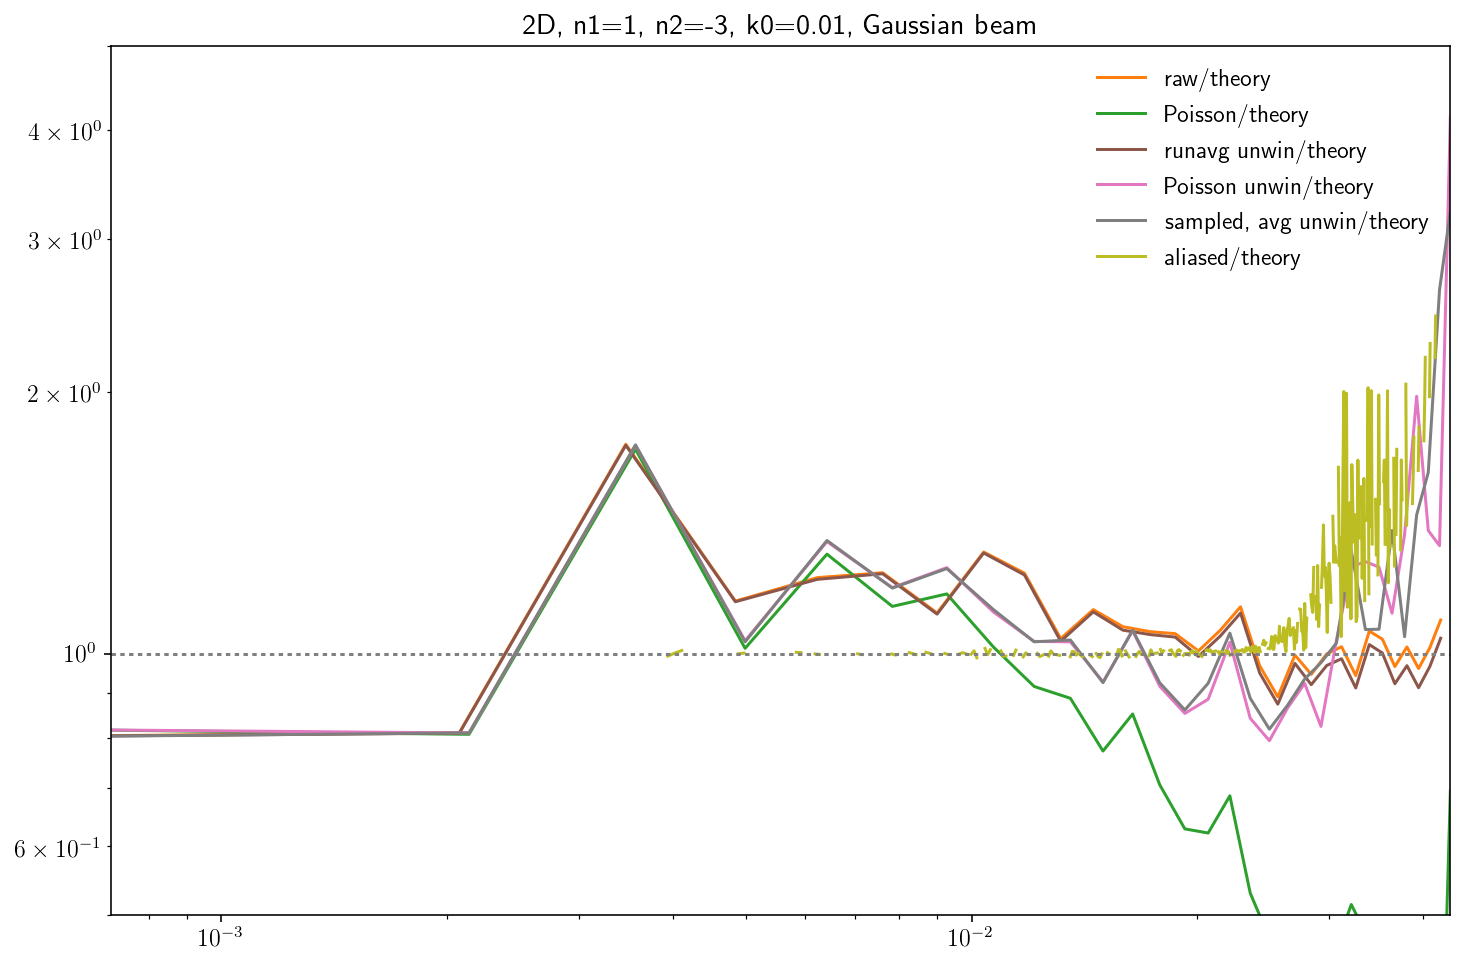

In [3]:
### test with Gaussian beam
# plt.rcParams['figure.figsize'] = (xsize, ysize)
n_in = 1024
n_out = 64
n_per_pix = 512

### n_in, n_out, n_per_pix = 1024, 64, 1024 gives same behaviour with and w/o beam (or n_out<=64)
### n_in, n_out, n_per_pix = 1024, 128, 1024 gives worse behaviour for Poisson sampling with beam (or n_out>=128)

ndim = 2
nsub = (n_in//n_out)**ndim
print("Number of sub-pix per pix =%d" % nsub)
print("cf. n_per_pix = %d" % n_per_pix)

nsamples=n_out**2*n_per_pix

n1=1; n2=-3; k0=0.01
title = "2D, n1=%g, n2=%g, k0=%g, Gaussian beam" % (n1, n2, k0)

def Pk(k, n1=1, n2=-3, k0=0.01):
    kk = k/(2*np.pi)
    with np.errstate(divide='ignore', invalid='ignore'):
        return np.where(kk<k0,(kk/k0)**n1, (kk/k0)**n2)
    
def beam(k, k_sigma = 0.02):
    kk = k/(2*np.pi)
    with np.errstate(divide='ignore', invalid='ignore'):
        return np.where(kk/k_sigma<4, np.exp(-0.5*(kk/k_sigma)**2), np.exp(-0.5*(4)**2)*(kk/k_sigma/4)**-2)

def kcut(k, k_cut=0.025):
    kk = k/(2*np.pi)
    return np.where(kk<k_cut, 1, 0)
    
def Pk_beam(k):
    return Pk(k)*beam(k)   #*kcut(k)

pixs.driver(n=Pk_beam, dims=(n_in, n_in), nsamples=nsamples, shrink_by=n_in//n_out, nk=n_out//2, maps=False,cutraw=1, 
            title=title)

## Test #2 — without beam-smearing

dims= (1024, 1024)
delta_k: shape= (1024, 513)
delta_r: shape= (1024, 1024)
shape_in (1024, 1024)
shape_out (64, 64)
len=1048576
vals[2097152]: 1.98791e-05 ± 0.0289496
final shape: (64, 64)
good/total: 4096/4096
orig: 5.42101e-20 ± 0.0289326
sampled: 5.46742e-06 ± 0.0236439
P[0]/eP[0]=1.05846e-29, shrink**4=65536
full spectra plotted. P[0]=3.31772e-34
sampled spectra plotted, eP[0]=3.13448e-05


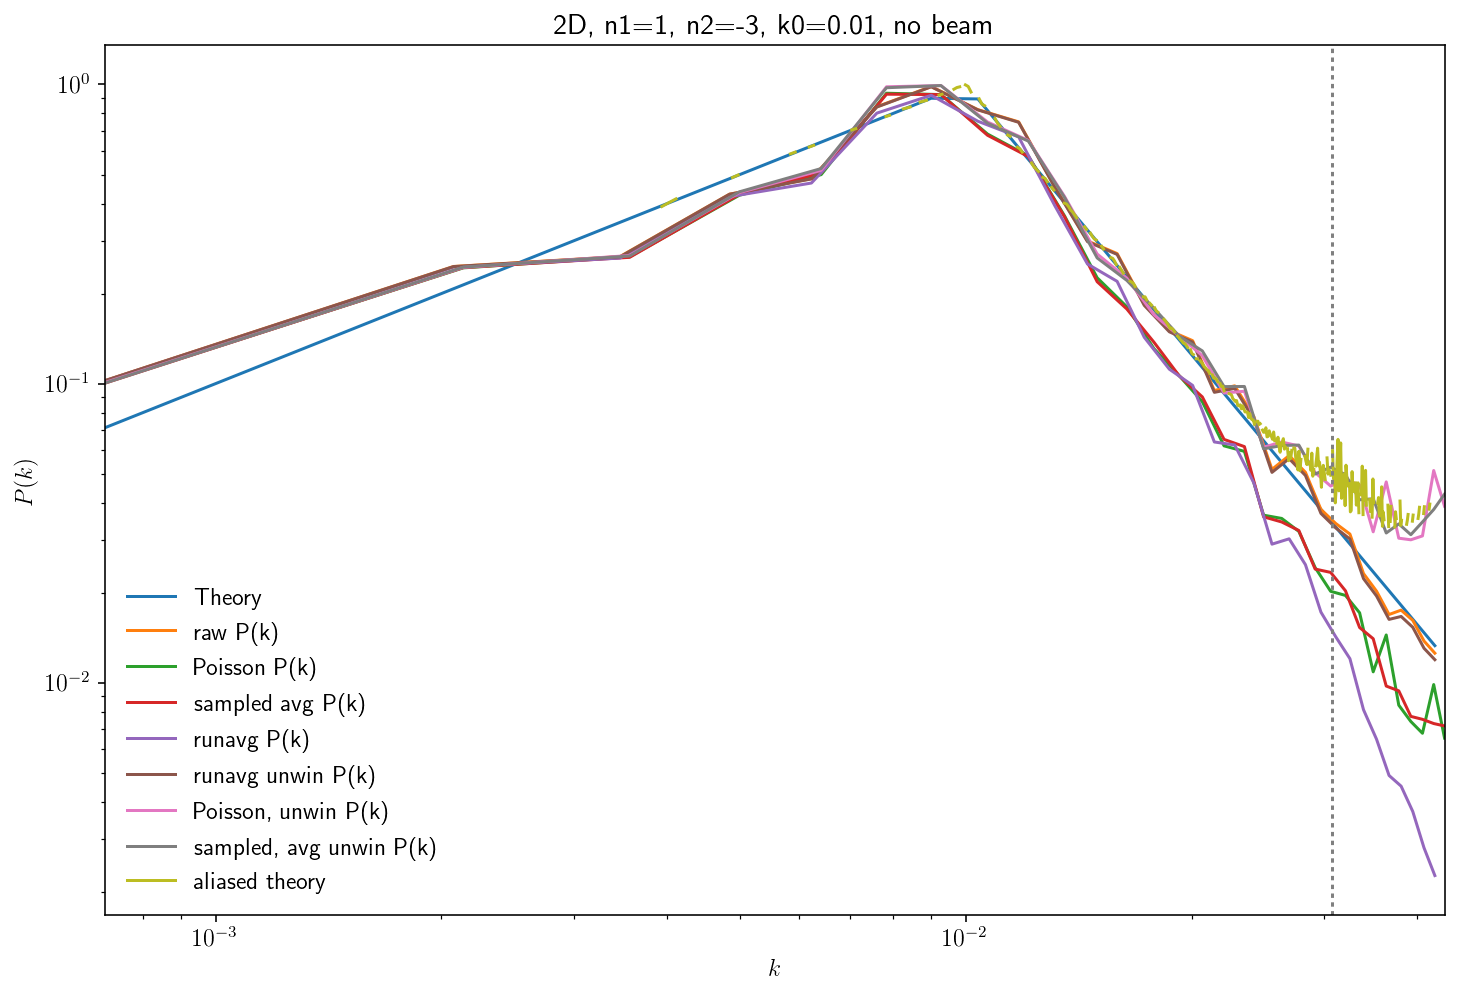

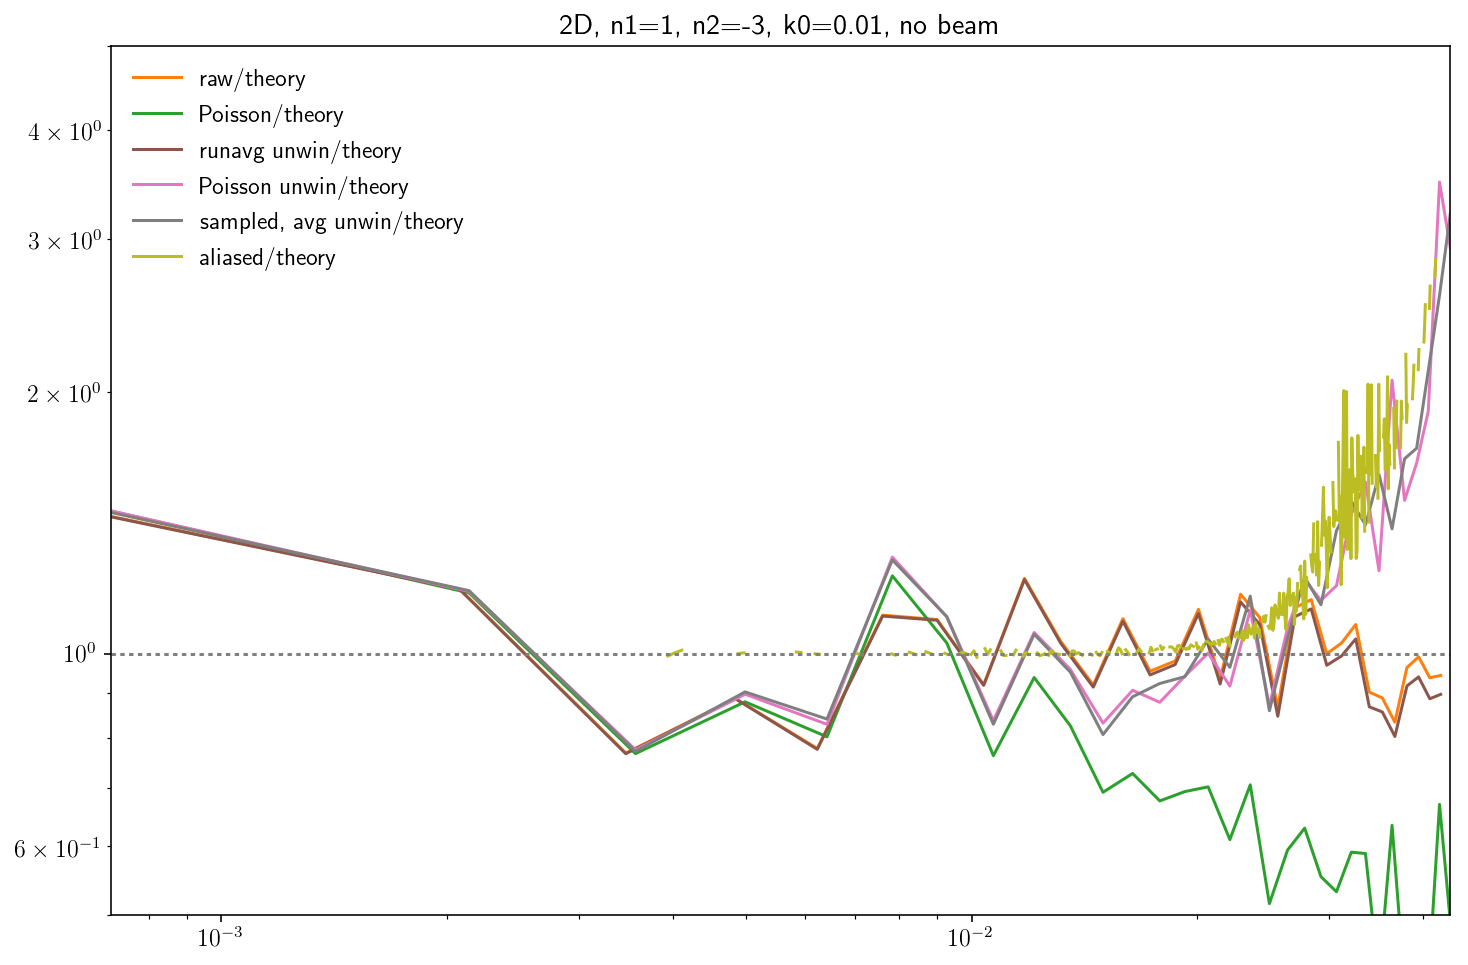

In [4]:
### test without beam (same P(k) as above)
# plt.rcParams['figure.figsize'] = (xsize, ysize)
title = "2D, n1=%g, n2=%g, k0=%g, no beam" % (n1, n2, k0)

def Pk_cut(k):
    return Pk(k) #*kcut(k)

pixs.driver(n=Pk_cut, dims=(n_in, n_in), nsamples=nsamples, shrink_by=n_in//n_out, nk=n_out//2, maps=False,
            cutraw=1, title=title)

## 1-D tests (can ignore)

 Number of sub-pix per pix =128
cf. n_per_pix = 1024
dims= (16384,)
delta_k: shape= (8193,)
delta_r: shape= (16384,)
shape_in (16384,)
shape_out (128,)
len=16384
vals[16777216]: 1.77575e-06 ± 0.0558356
final shape: (128,)
good/total: 128/128
orig: 8.67362e-19 ± 0.0558285
sampled: 3.60237e-06 ± 0.049412
P[0]/eP[0]=8.7774e-28, shrink**4=16384
full spectra plotted. P[0]=1.86621e-34
sampled spectra plotted, eP[0]=2.12616e-07


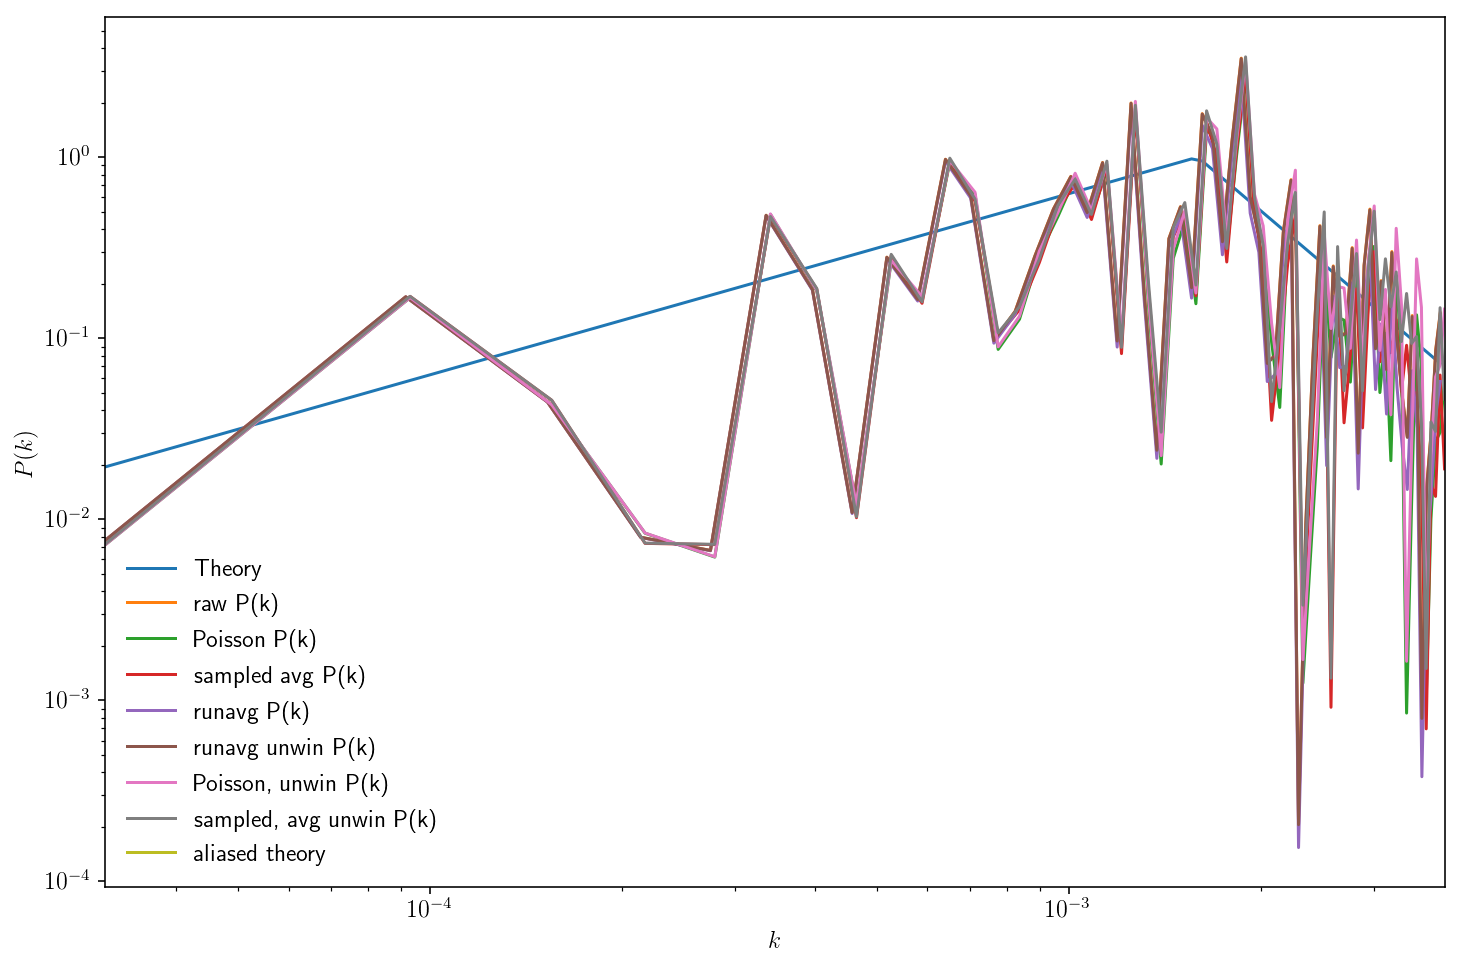

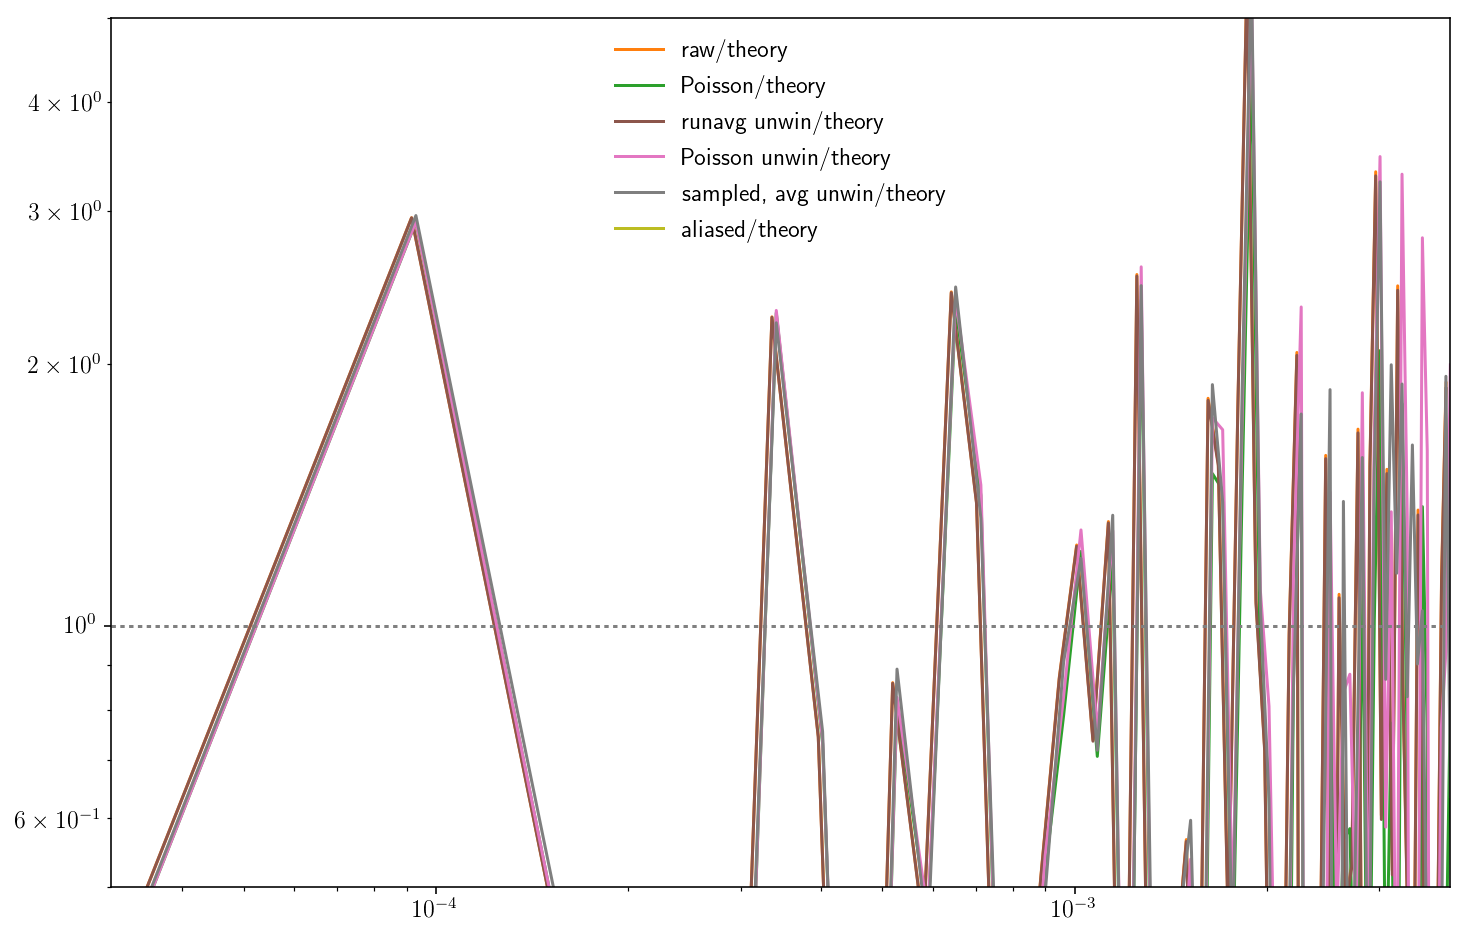

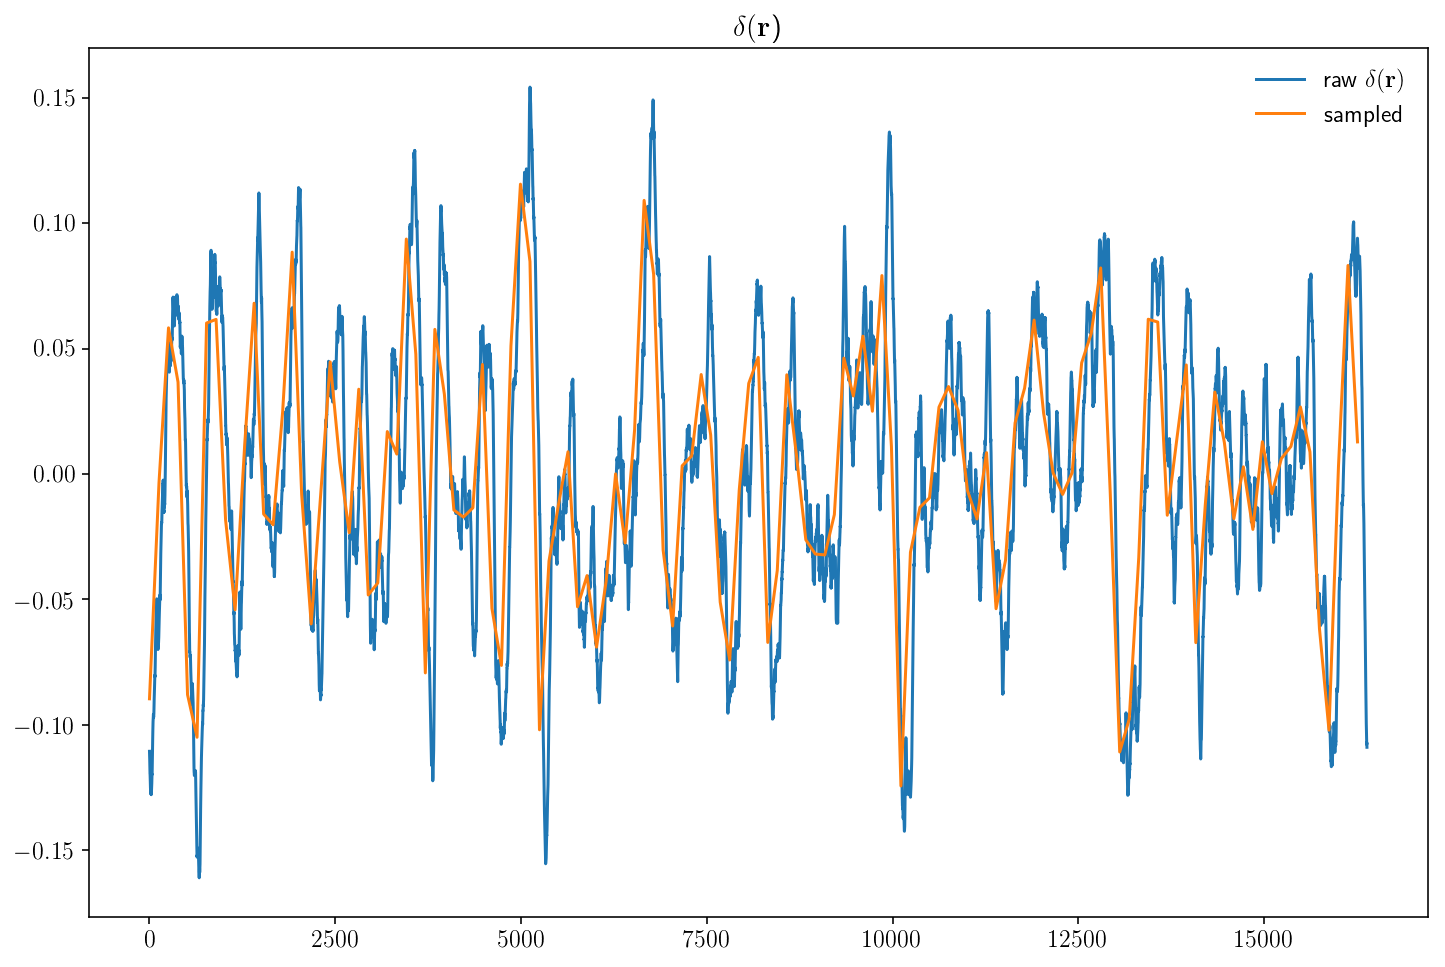

In [5]:
## 1d???
# reload(pixs)
n_in = 2**14
n_out = 128
n_per_pix = 1024

nsamples=n_out**2*n_per_pix

ndim = 1
nsub = (n_in/n_out)**ndim
print(" Number of sub-pix per pix =%d" % nsub)
print("cf. n_per_pix = %d" % n_per_pix)

def Pk(k, n1=1, n2=-3, k0=0.01):
    with np.errstate(divide='ignore'):
        return np.where(k<k0,(k/k0)**n1, (k/k0)**n2)
    
def beam(k, k_sigma = 0.01):
    return np.exp(-0.5*(k/k_sigma)**2)

def Pk_full(k):
    return Pk(k)  #*beam(k)

pixs.driver(n=Pk_full, dims=(n_in,), nsamples=nsamples, shrink_by=n_in//n_out, nk=n_out//2, maps=True, cutraw=1)

## Pixel window comparisons

0.420301049418


(0, 2)

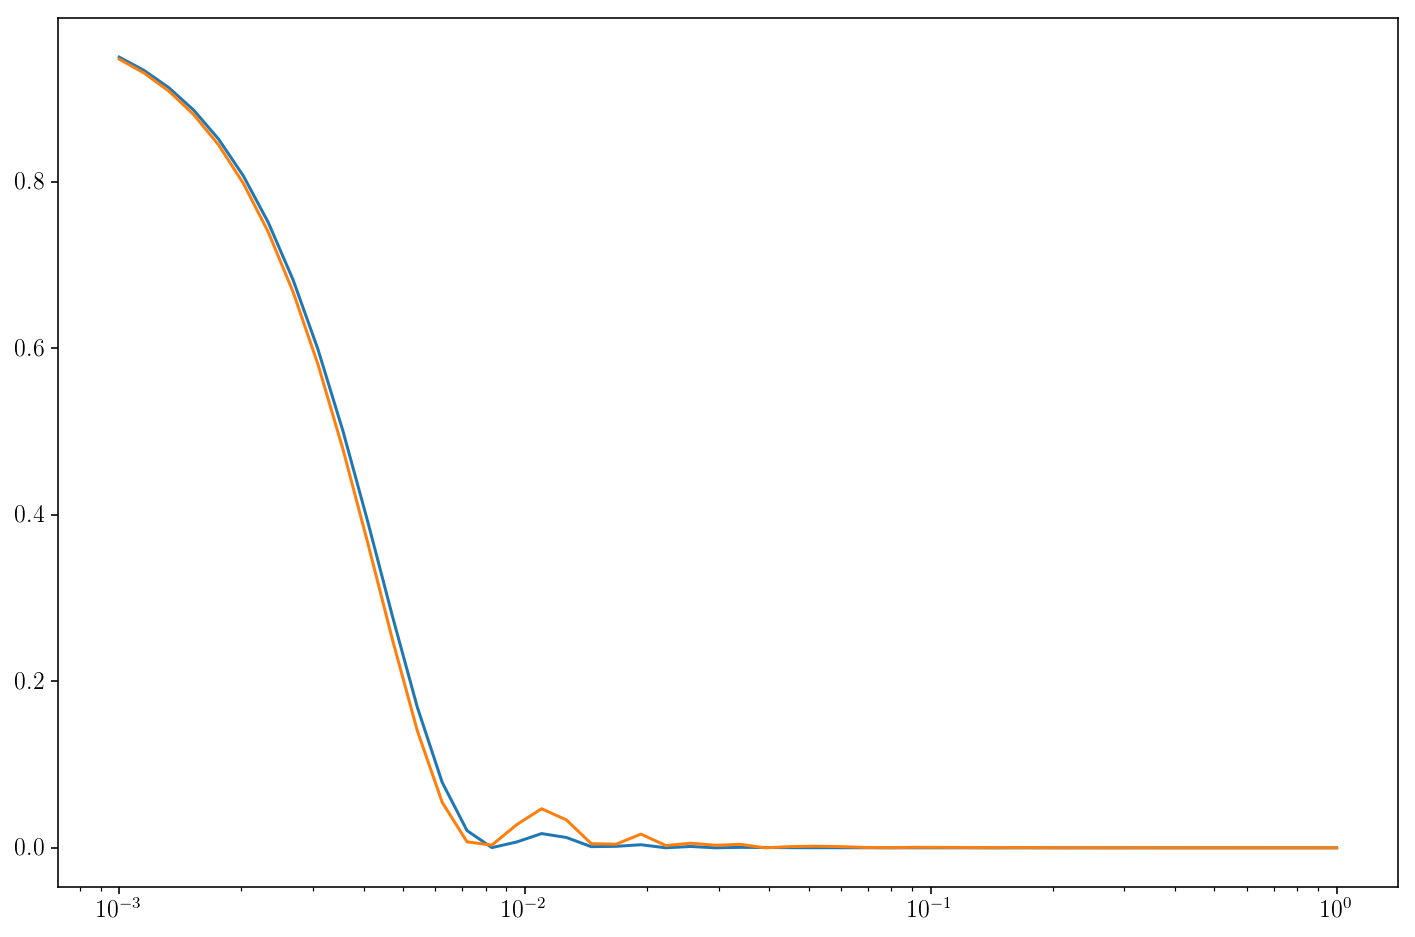

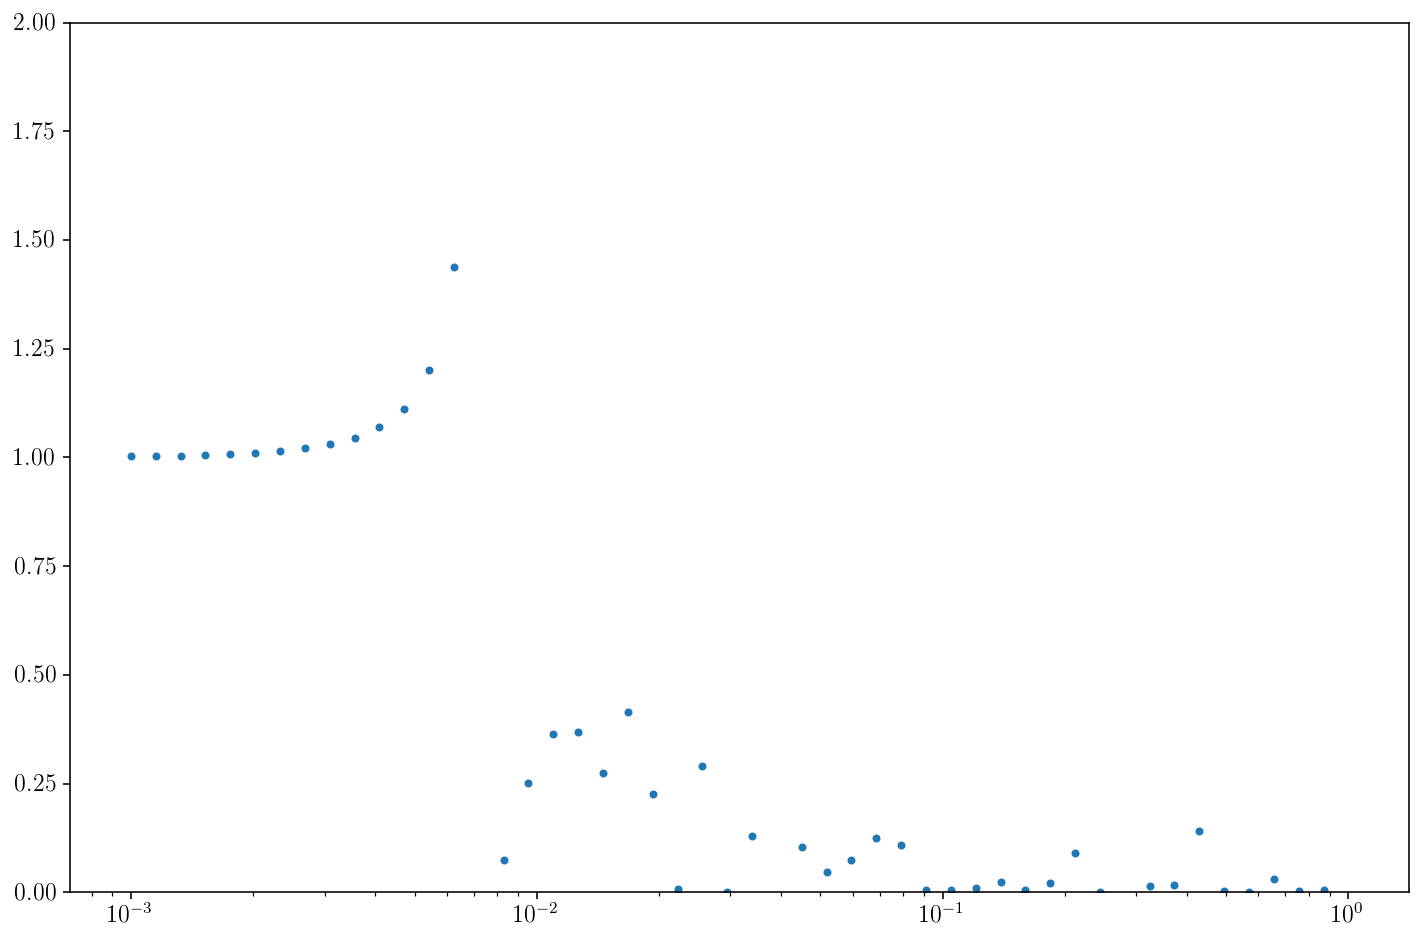

In [6]:
karr = np.logspace(-3,0,50)
plt.semilogx(karr, pixs.pixelWindow2D(karr, n_in//n_out)**2)
plt.semilogx(karr, pixs.pixelWindow1D(karr, n_in//n_out)**2)
print(pixs.pixelWindow2D(10**-1.5,2048/128)**2)   ### checked against mathematica: Wsquare[10^-1.5, 2048/128]^2 = 0.9798
plt.figure()
plt.semilogx(karr, pixs.pixelWindow2D(karr, n_in//n_out)**2/pixs.pixelWindow1D(karr, n_in//n_out)**2, '.')
plt.ylim(0,2)